# Analysis of cross-validation outcomes

In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
import matplotlib

## Molecules and corresponding n. of observables

total n. of observables n_exp and n. of observables used in test nobs_test

In [2]:
Sequences=['AAAA','CCCC','GACC','UUUU','UCAAUC'] # molecules used in cross validation
Sequences_all=Sequences+['CAAU','UCUCGU']

In [3]:
a=[[8, 9, 11, 36, 244], [8, 8, 11, 39, 377], [6, 9, 11, 27, 246], [8, 9, 12, 20, 285], [6, 9, 10, 9, 283]]
tetramers=['AAAA','CAAU','CCCC','GACC','UUUU']

n_exp_all={}

for i,s in enumerate(tetramers):
    n_exp_all[s]=[np.sum(a[i][:-1]),a[i][-1]]

n_exp_all['UCAAUC']=[102,581]
n_exp_all['UCUCGU']=[69,4]

print('all molecules: \n',n_exp_all)

all molecules: 
 {'AAAA': [64, 244], 'CAAU': [66, 377], 'CCCC': [53, 246], 'GACC': [49, 285], 'UUUU': [34, 283], 'UCAAUC': [102, 581], 'UCUCGU': [69, 4]}


In [4]:
n_exp=[]
for s in Sequences: n_exp.append(n_exp_all[s])
n_exp=np.array(n_exp)

print('selected molecules:\n',n_exp)

selected molecules:
 [[ 64 244]
 [ 53 246]
 [ 49 285]
 [ 34 283]
 [102 581]]


In [5]:
nobs_test=np.rint(30/100*n_exp)

# previous
if_previous=False
if if_previous:
    nobs_test=np.zeros((len(Sequences),2))
    for i in range(len(Sequences)):
        nobs_test[i,:]=[10,20]  # also uNOEs

nobs_test=nobs_test.astype(int)
print(nobs_test)

[[ 19  73]
 [ 16  74]
 [ 15  86]
 [ 10  85]
 [ 31 174]]


## Cross validation

Save output data for the whole data set in a compatible way
(i.e. same column names and possibly same $\alpha$, $\beta$ values)

### a. ensemble refinement

select folder

In [6]:
# if_uNOEs = False
# userdoc_ER = 'Results/ER_no_uNOEs'

if_uNOEs = True
userdoc_ER = 'Results/ER_skip10'
# userdoc_ER = 'Results/ER_skip100'

load data

In [7]:
def read_results_ER(Sequences,if_uNOEs,userdoc_ER,n_exp,nobs_test,common_seed): # WATCH OUT: merge

    # 1. read csv (one for each molecule)
    data_ER=[]

    for i in range(len(Sequences)):
        if if_uNOEs: range_usecols=18
        else: range_usecols=15
        data_ER.append(pandas.read_csv(os.path.join(userdoc_ER,"%s_table" % Sequences[i]),header=0,usecols=range(range_usecols)))
        if common_seed is not None: data_ER[i]=data_ER[i][data_ER[i]['seed']<=common_seed] # common seeds
        data_ER[i]=data_ER[i].drop(columns=data_ER[i].columns[data_ER[i].columns.str.startswith('Unnamed:')])
        data_ER[i]=data_ER[i].drop(data_ER[i][data_ER[i]['alpha']=='alpha'].index)#,inplace=True)
        data_ER[i]=data_ER[i].sort_values(by=['alpha'],ignore_index=True)

    # 2. merge them (better: pandas.concat, but then you have to specify different names for columns, depending on the molecules)
    # suffixes only applies to column names that are duplicated by merged
    if len(Sequences)>=5:
        merged=data_ER[0]
        merged1=merged.merge(data_ER[1],on=('alpha','seed'),left_index=True,right_index=True,suffixes=('0', '1'))
        merged2=merged1.merge(data_ER[2],on=('alpha','seed'),left_index=True,right_index=True,suffixes=('', '2'))
        merged3=merged2.merge(data_ER[3],on=('alpha','seed'),left_index=True,right_index=True,suffixes=('2', '3'))
        merged4=merged3.merge(data_ER[4],on=('alpha','seed'),left_index=True,right_index=True,suffixes=('', '4'))

    if len(Sequences)>5 and len(Sequences)==7:
        merged5=merged4.merge(data_ER[5],on=('alpha','seed'),left_index=True,right_index=True,suffixes=('4','5'))
        merged6=merged5.merge(data_ER[6],on=('alpha','seed'),left_index=True,right_index=True,suffixes=('','6'))
        data_ER=merged6
        del merged5,merged6

    elif len(Sequences)==5:
        data_ER=merged4
        del merged,merged1,merged2,merged3,merged4

    else: print('error')

    # 2a. drop repeated columns (time, niter, nfail)
    filter_col = [col for col in data_ER if col.startswith('time') or col.startswith('niter') or col.startswith('nfail')]
    data_ER=data_ER.drop(columns=filter_col)

    # 2b. rename columns consistently
    if len(Sequences)==5:
        data_ER.rename(columns={'train_lossf': 'train_lossf4', 'test_lossf': 'test_lossf4', 'errorf[0][0]': 'errorf[0][0]4', 'errorf1[0][0]': 'errorf1[0][0]4', 'errorf2[0][0]': 'errorf2[0][0]4', 'train_Srel[0]': 'train_Srel[0]4', 'test_Srel[0]': 'test_Srel[0]4'},inplace=True)
        if if_uNOEs: data_ER.rename(columns={'errorf[0][1]' : 'errorf[0][1]4', 'errorf1[0][1]' : 'errorf1[0][1]4', 'errorf2[0][1]' : 'errorf2[0][1]4'},inplace=True)
    elif len(Sequences)==7:
        data_ER.rename(columns={'train_lossf': 'train_lossf6', 'test_lossf': 'test_lossf6', 'errorf[0][0]': 'errorf[0][0]6', 'errorf1[0][0]': 'errorf1[0][0]6', 'errorf2[0][0]': 'errorf2[0][0]6', 'train_Srel[0]': 'train_Srel[0]6', 'test_Srel[0]': 'test_Srel[0]6'},inplace=True)
        if if_uNOEs: data_ER.rename(columns={'errorf[0][1]' : 'errorf[0][1]6', 'errorf1[0][1]' : 'errorf1[0][1]6', 'errorf2[0][1]' : 'errorf2[0][1]6'},inplace=True)
    else: print('error')

    data_ER=data_ER.astype(float)

    # 3. compute totals (loss function, errors, relative entropies)
    length=len(Sequences)
    data_ER['train_lossf']=np.sum(data_ER[['train_lossf%i' %i for i in range(length)]],axis=1)
    data_ER['test_lossf']=np.sum(data_ER[['test_lossf%i' %i for i in range(length)]],axis=1)
    data_ER['errorf']=np.sum(data_ER[['errorf[0][0]%i' %i for i in range(length)]],axis=1)
    data_ER['errorf1']=np.sum(data_ER[['errorf1[0][0]%i' %i for i in range(length)]],axis=1)
    data_ER['errorf2']=np.sum(data_ER[['errorf2[0][0]%i' %i for i in range(length)]],axis=1)
    data_ER['errorf_test']=np.sum(data_ER[['errorf1','errorf2']],axis=1)

    if if_uNOEs:
        data_ER['errorf_uNOEs']=np.sum(data_ER[['errorf[0][1]%i' %i for i in range(length)]],axis=1)
        data_ER['errorf1_uNOEs']=np.sum(data_ER[['errorf1[0][1]%i' %i for i in range(length)]],axis=1)
        data_ER['errorf2_uNOEs']=np.sum(data_ER[['errorf2[0][1]%i' %i for i in range(length)]],axis=1)

        data_ER['errorf_all']=np.sum(data_ER[['errorf','errorf_uNOEs']],axis=1)
        data_ER['errorf1_all']=np.sum(data_ER[['errorf1','errorf1_uNOEs']],axis=1)
        data_ER['errorf2_all']=np.sum(data_ER[['errorf2','errorf2_uNOEs']],axis=1)
        data_ER['errorf_all_test']=np.sum(data_ER[['errorf1','errorf2','errorf1_all','errorf2_all']],axis=1)

    data_ER['train_Srel']=np.sum(data_ER[['train_Srel[0]%i' %i for i in range(length)]],axis=1)
    data_ER['test_Srel']=np.sum(data_ER[['test_Srel[0]%i' %i for i in range(length)]],axis=1)

    filter_col = [col for col in data_ER if col.startswith('train_lossf[') or col.startswith('test_lossf[')]
    data_ER=data_ER.drop(columns=filter_col)

    # 4. beta column
    data_ER['beta']=np.inf

    # 5. rename other columns consistently
    cols0=['train_lossf%i' %i for i in range(length)]+['test_lossf%i' %i for i in range(length)]+['train_Srel[0]%i' %i for i in range(length)]+['test_Srel[0]%i' %i for i in range(length)]+['train_Srel','test_Srel']
    cols1=['train_lossf[%i]' %i for i in range(length)]+['test_lossf[%i]' %i for i in range(length)]+['train_Srel_alpha[%i]' %i for i in range(length)]+['test_Srel_alpha[%i]' %i for i in range(length)]+['train_Srel_alpha','test_Srel_alpha']

    for i in range(len(cols0)):
        data_ER.rename(columns={cols0[i]: cols1[i]},inplace=True)

    data_ER['train_Srel_beta']=0
    for i in range(len(Sequences)):
        data_ER['train_Srel_beta[%i]' %i]=0

    data_ER['test_Srel_beta']=0
    for i in range(len(Sequences)):
        data_ER['test_Srel_beta[%i]' %i]=0

    data_ER['train_Srel']=data_ER['train_Srel_alpha']
    for i in range(len(Sequences)):
        data_ER['train_Srel[%i]' %i]=data_ER['train_Srel_alpha[%i]' %i]

    data_ER['test_Srel']=data_ER['test_Srel_alpha']
    for i in range(len(Sequences)):
        data_ER['test_Srel[%i]' %i]=data_ER['test_Srel_alpha[%i]' %i]

    data_ER=data_ER[sorted(data_ER.columns)]

    # 6. sort columns
    data_ER=data_ER[sorted(data_ER.columns)]

    # 7. compute reduced chi2

    #filter_col1 = [col for col in data_ER if col.startswith('errorf[')]
    s1=['errorf[0][0]%i','errorf1[0][0]%i','errorf2[0][0]%i']
    #filter_col1 = ['errorf[0][0]%i' %i for i in range(len(Sequences))]
    #filter_col2 = [col for col in data_ER if col.startswith('errorf1[')]
    #filter_col3 = [col for col in data_ER if col.startswith('errorf2[')]

    if if_uNOEs: s=['train_red.chi2[%i]_noUNOEs','test_red.chi2[%i]_newobs_noUNOEs','test_red.chi2[%i]_sameobs_noUNOEs','test_red.chi2[%i]_noUNOEs']
    else: s=['train_red.chi2[%i]','test_red.chi2[%i]_newobs','test_red.chi2[%i]_sameobs','test_red.chi2[%i]']

    for i in range(len(Sequences)):
        data_ER[s[0] %i]=data_ER[s1[0] %i]*2/(n_exp[i,0]-nobs_test[i,0])
        data_ER[s[1] %i]=data_ER[s1[1] %i]*2/nobs_test[i,0]
        data_ER[s[2] %i]=data_ER[s1[2] %i]*2/(n_exp[i,0]-nobs_test[i,0])
        data_ER[s[3] %i]=(data_ER[s1[1] %i]+data_ER[s1[2] %i])*2/n_exp[i,0]


    #data_ER=data_ER.drop(columns=filter_col2)
    #data_ER=data_ER.drop(columns=filter_col3)

    if if_uNOEs:
        #filter_col1 = [col for col in data_ER if col.startswith('errorf[')]
        s2=['errorf[0][1]%i','errorf1[0][1]%i','errorf2[0][1]%i']
        #filter_col1 = ['errorf[0][0]%i' %i for i in range(len(Sequences))]
        #filter_col2 = [col for col in data_ER if col.startswith('errorf1[')]
        #filter_col3 = [col for col in data_ER if col.startswith('errorf2[')]

        for i in range(length):
            data_ER['train_red.chi2[%i]_UNOEs' %i]=data_ER[s2[0] %i]*2/(n_exp[i,1]-nobs_test[i,1])
            data_ER['test_red.chi2[%i]_newobs_UNOEs' %i]=data_ER[s2[1] %i]*2/nobs_test[i,1]
            data_ER['test_red.chi2[%i]_sameobs_UNOEs' %i]=data_ER[s2[2] %i]*2/(n_exp[i,1]-nobs_test[i,1])
            data_ER['test_red.chi2[%i]_UNOEs' %i]=(data_ER[s2[1] %i]+data_ER[s2[2] %i])*2/n_exp[i,1]

        for i in range(length):
            data_ER['train_red.chi2[%i]' %i]=(data_ER[s1[0] %i]+data_ER[s2[0] %i])*2/(n_exp[i,0]-nobs_test[i,0]+n_exp[i,1]-nobs_test[i,1])
            data_ER['test_red.chi2[%i]_newobs' %i]=(data_ER[s1[1] %i]+data_ER[s2[1] %i])*2/(nobs_test[i,0]+nobs_test[i,1])
            data_ER['test_red.chi2[%i]_sameobs' %i]=(data_ER[s1[2] %i]+data_ER[s2[2] %i])*2/(n_exp[i,0]-nobs_test[i,0]+n_exp[i,1]-nobs_test[i,1])
            data_ER['test_red.chi2[%i]' %i]=(data_ER[s1[1] %i]+data_ER[s1[2] %i]+data_ER[s2[1] %i]+data_ER[s2[2] %i])*2/(n_exp[i,0]+n_exp[i,1])

    if if_uNOEs:
        for j in range(3):
            filter_col=[s2[j] %i for i in range(length)]
            data_ER=data_ER.drop(columns=filter_col)

    for j in range(3):
        filter_col=[s1[j] %i for i in range(length)]
        data_ER=data_ER.drop(columns=filter_col)

    cols=['train_red.chi2[%i]' %i for i in range(length)]
    data_ER['train_red.chi2']=np.sum(data_ER[cols]*np.sum(n_exp-nobs_test,axis=1),axis=1)/np.sum(n_exp-nobs_test)
    cols=['test_red.chi2[%i]_sameobs' %i for i in range(length)]
    data_ER['test_red.chi2_sameobs']=np.sum(data_ER[cols]*np.sum(n_exp-nobs_test,axis=1),axis=1)/np.sum(n_exp-nobs_test)
    cols=['test_red.chi2[%i]_newobs' %i for i in range(length)]
    data_ER['test_red.chi2_newobs']=np.sum(data_ER[cols]*np.sum(nobs_test,axis=1),axis=1)/np.sum(nobs_test)
    cols=['test_red.chi2[%i]' %i for i in range(length)]
    data_ER['test_red.chi2']=np.sum(data_ER[cols]*np.sum(n_exp,axis=1),axis=1)/np.sum(n_exp)

    # 8. compute averages, standard deviations and counts
    stats=data_ER.pivot_table(index='alpha',columns='beta',aggfunc=['mean','std','count'])
    
    return data_ER,stats

In [8]:
common_seed=20 # None if you don't want this limitation
data_ER,data_ER_pivot=read_results_ER(Sequences,if_uNOEs,userdoc_ER,n_exp,nobs_test,common_seed)


In [9]:
s='train_loss'
#s='test_red.chi2_sameobs'
filter_col=['seed','alpha']+[col for col in data_ER if col.startswith(s)]
data_ER[(data_ER['alpha']==np.inf) & (data_ER['seed']==10)][filter_col]

,seed,alpha,train_lossf,train_lossf[0],train_lossf[1],train_lossf[2],train_lossf[3],train_lossf[4]
283,10.0,inf,18168.372775,628.867693,12972.765072,48.213521,269.009001,4249.517488


alpha:  [0.e+00 1.e-02 1.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02
 1.e+03 1.e+04 1.e+05 1.e+06    inf]
train_Srel [-3.81409190e+01 -2.97390515e+01 -1.53460621e+01 -1.13941744e+01
 -6.85638892e+00 -4.61431622e+00 -3.29254019e+00 -2.30870880e+00
 -1.85150287e+00 -8.35304914e-01 -2.30283579e-01 -2.48315695e-02
 -6.13590500e-04  0.00000000e+00]
test_Srel [-5.06604943e+01 -4.26259946e+01 -2.25257365e+01 -1.58238765e+01
 -7.67291651e+00 -4.72876843e+00 -3.31570206e+00 -2.31451307e+00
 -1.85431443e+00 -8.35571143e-01 -2.30354087e-01 -2.48173400e-02
 -6.12042000e-04  0.00000000e+00]


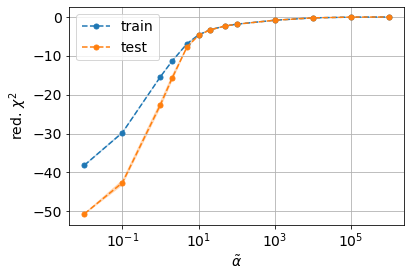

In [10]:
plt.figure()#figsize=(8,6))
plt.rcParams['font.size'] = 14

s = ['train_Srel','test_Srel']
labels = ['train','test']

#s=['train_red.chi2','test_red.chi2_sameobs','test_red.chi2_newobs']#,'test_red.chi2']
#labels=['training','test frames','test observables']#,'test all']

#s=['train_red.chi2[%i]_noUNOEs' %i,'test_red.chi2[%i]_sameobs_noUNOEs' %i,'test_red.chi2[%i]_newobs_noUNOEs' %i,'test_red.chi2[%i]_noUNOEs' %i]
#labels=['training','test, same obs.','test, new obs.','test, all obs.']
#labels=[r'$-S_{rel}$ training',r'$-S_{rel}$ new frames']

print('alpha: ',np.array(data_ER_pivot.index))
for j in range(len(s)):
    w=np.array(data_ER_pivot['mean'][s[j]])[1:,0]
    print(s[j],w)
    erronmean=np.array(data_ER_pivot['std'][s[j]])[1:,0]/np.sqrt(np.array(data_ER_pivot['count'][s[j]])[1:,0])
    plt.plot(data_ER_pivot.index[1:],w,'.--',label=labels[j],markersize=10)
    plt.fill_between(data_ER_pivot.index[1:],w-erronmean,w+erronmean,alpha=0.3)

plt.xscale('log')
#plt.yscale('symlog')
#plt.ylim(bottom=0.1)
#plt.ylim([0.01,10])
plt.grid()
#plt.title(r'reduced $\chi^2$ - cross validation')#all training molecules')
plt.xlabel(r'$\tilde{\alpha}$')
plt.ylabel(r'red. $\chi^2$')
plt.legend()

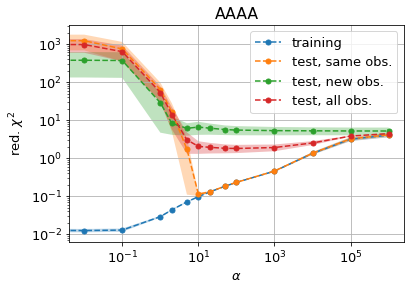

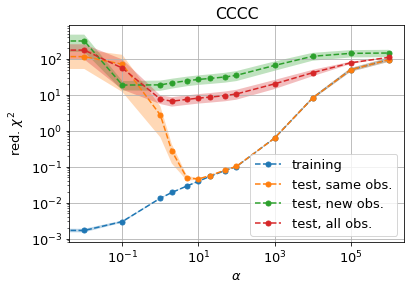

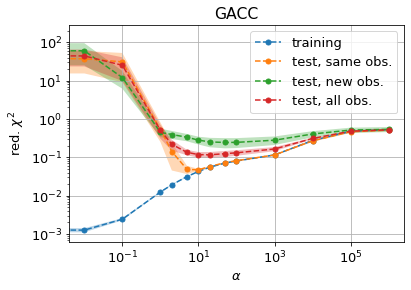

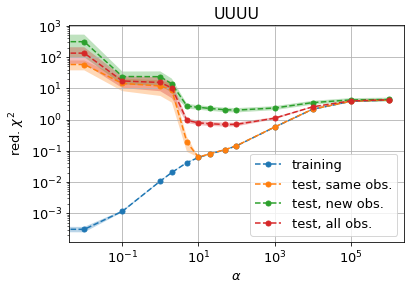

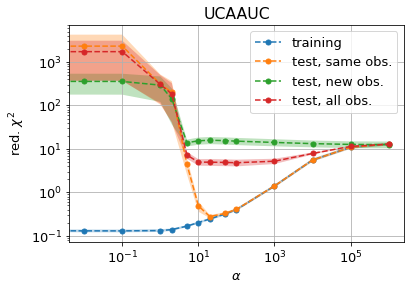

In [11]:
#i=1
#font = {'family' : 'normal','weight' : 'bold','size'   : 10}
#font={'size' : 10}
#matplotlib.rc('font', **font)

for i in range(len(Sequences)):
    plt.figure()#figsize=(8,6))
    plt.rcParams['font.size'] = 13

    s=['train_red.chi2[%i]' %i,'test_red.chi2[%i]_sameobs' %i,'test_red.chi2[%i]_newobs' %i,'test_red.chi2[%i]' %i]
    #s=['train_red.chi2[%i]_noUNOEs' %i,'test_red.chi2[%i]_sameobs_noUNOEs' %i,'test_red.chi2[%i]_newobs_noUNOEs' %i,'test_red.chi2[%i]_noUNOEs' %i]
    labels=['training','test, same obs.','test, new obs.','test, all obs.']

    for j in range(4):
        w=np.array(data_ER_pivot['mean'][s[j]])[:,0]
        erronmean=np.array(data_ER_pivot['std'][s[j]])[:,0]/np.sqrt(np.array(data_ER_pivot['count'][s[j]])[:,0])
        plt.plot(data_ER_pivot.index,w,'.--',label=labels[j],markersize=10)
        plt.fill_between(data_ER_pivot.index,w-erronmean,w+erronmean,alpha=0.3)

    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(bottom=0.1)
    #plt.ylim([0.01,10])
    plt.grid()
    plt.title(Sequences[i])
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'red. $\chi^2$')
    plt.legend()


In [12]:
s=['test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))]
np.sum(data_ER_pivot['mean'][s],axis=1)

alpha
0.00           711.434580
0.01          1415.208093
0.10           780.043011
1.00           364.116220
2.00           185.107053
5.00            47.419798
10.00           51.245291
20.00           52.809147
50.00           54.570636
100.00          57.406145
1000.00         86.968195
10000.00       139.257396
100000.00      163.677827
1000000.00     166.764430
inf            167.053820
dtype: float64

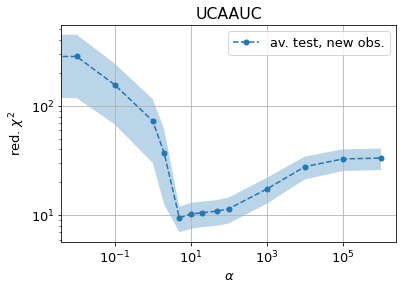

In [13]:
plt.figure()#figsize=(8,6))
plt.rcParams['font.size'] = 13

s=['test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))]
labels=['av. test, new obs.']#training','test, same obs.','test, new obs.','test, all obs.']

w=np.mean(data_ER_pivot['mean'][s],axis=1)
erronmean=np.mean((data_ER_pivot['std'][s])/np.sqrt(np.array(data_ER_pivot['count'][s])),axis=1)
plt.plot(data_ER_pivot.index,w,'.--',label=labels[0],markersize=10)
plt.fill_between(data_ER_pivot.index,w-erronmean,w+erronmean,alpha=0.3)

plt.xscale('log')
plt.yscale('log')
#plt.ylim(bottom=0.1)
#plt.ylim([0.01,10])
plt.grid()
plt.title(Sequences[i])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'red. $\chi^2$')
plt.legend()

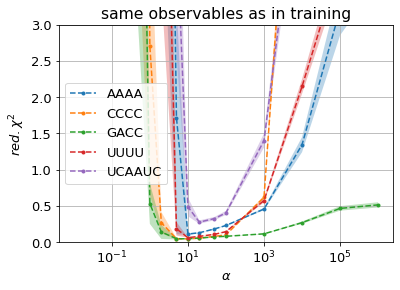

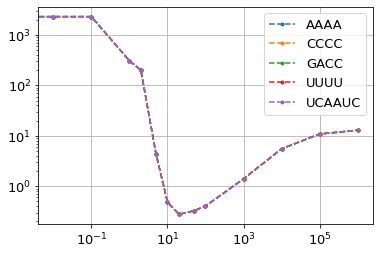

In [14]:
#i=1
for i in range(len(Sequences)):
    s='test_red.chi2[%i]_sameobs' %i
    #s='train_red.chi2[%i]' %i
    #s='test_Srel[%i]' %i
    #s='train_red.chi2[%i]' %i
    #w=np.array(data_ER_pivot['first'][s])[:,0]#/data_ER_pivot.index
    #plt.plot(data_ER_pivot.index,w,'.--',label=Sequences[i])
    w=np.array(data_ER_pivot['mean'][s])[:,0]
    erronmean=np.array(data_ER_pivot['std'][s])[:,0]/np.sqrt(np.array(data_ER_pivot['count'][s])[:,0])
    plt.plot(data_ER_pivot.index,w,'.--',label=Sequences[i])
    plt.fill_between(data_ER_pivot.index,w-erronmean,w+erronmean,alpha=0.3)


plt.xscale('log')
#plt.yscale('log')
plt.ylim([0,3])
plt.legend()
plt.ylabel(r'$red.\chi^2$')
plt.xlabel(r'$\alpha$')
plt.title('same observables as in training')
plt.grid()

plt.figure()
w=np.zeros(len(data_ER_pivot.index))
for i in range(len(Sequences)):
    #s='test_lossf[%i]' %i
    w=np.array(data_ER_pivot['mean'][s])[:,0]
    plt.plot(data_ER_pivot.index,w,'.--',label=Sequences[i])

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

### b. force field fitting

In [15]:
if_uNOEs = True

userdoc_FFF = 'Results/ERFFF_alphaonly_skip10'
# userdoc_FFF = 'Results/ERFFF_sincos_skip10'
# userdoc_FFF = 'Results/ERFFF_sincos_skip100'
# userdoc_FFF = 'Results/ERFFF_sincos_alphazeta_skip10'
# userdoc_FFF = 'Results/ERFFF_sincos_alphazeta_skip100'
# userdoc_FFF = 'Results/ERFFF_chi_skip10'

In [16]:
def read_results_FFF(Sequences,if_uNOEs,userdoc_FFF,n_exp,nobs_test):

    # 1. read csv
    cols=pandas.read_csv(os.path.join(userdoc_FFF,"ff_table"),header=0,nrows=0)
    length=len(cols.columns)
    data_FF=pandas.read_csv(os.path.join(userdoc_FFF,"ff_table"),header=None,usecols=range(length),skiprows=[0])
    data_FF.columns=cols.columns
    data_FF=data_FF.drop(columns=data_FF.columns[data_FF.columns.str.startswith('Unnamed:')])
    data_FF=data_FF.drop(data_FF[data_FF.alpha=='alpha'].index)
    #data_FF=data_FF[data_FF['seed']<9]

    data_FF=data_FF.astype(float)

    # 2. alpha column
    #data_FF=data_FF.drop(columns=['times','niter','fail'])

    data_FF['alpha']=np.inf

    # 3. rename columns consistently

    if not if_uNOEs:
        #all_FF.rename(columns={'redchi2[0][0]': 'red.chi2[0]', 'redchi2[1][0]': 'red.chi2[1]', 'redchi2[2][0]': 'red.chi2[2]', 'redchi2[3][0]': 'red.chi2[3]', 'redchi2[4][0]': 'red.chi2[4]'}, inplace=True)
        data_FF.rename(columns={'redchi2[%i][0]' %i: 'train_red.chi2[%i]' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2_1[%i][0]' %i: 'test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2_2[%i][0]' %i: 'test_red.chi2[%i]_sameobs' %i for i in range(len(Sequences))}, inplace=True)
        #all_FF=all_FF.drop(columns=['time','niter'])
    if if_uNOEs:
        data_FF.rename(columns={'redchi2[%i][0]' %i: 'train_red.chi2[%i]_noUNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2_1[%i][0]' %i: 'test_red.chi2[%i]_newobs_noUNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2_2[%i][0]' %i: 'test_red.chi2[%i]_sameobs_noUNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2[%i][1]' %i: 'train_red.chi2[%i]_UNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2_1[%i][1]' %i: 'test_red.chi2[%i]_newobs_UNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_FF.rename(columns={'redchi2_2[%i][1]' %i: 'test_red.chi2[%i]_sameobs_UNOEs' %i for i in range(len(Sequences))}, inplace=True)


    filter_col=[col for col in data_FF if col.startswith('test_kish') or col.startswith('test_relkish') or col.startswith('relkish') or col.startswith('kish')]
    data_FF=data_FF.drop(columns=filter_col)

    #for i in range(len(Sequences)):
    #    all_FF['red.chi2[%i]' % i]=all_FF['errorf[%s][0]' %i]*2/n_exp[i,0]

    #filter_col=[col for col in all_FF if col.startswith('errorf')]
    #all_ER=all_ER.drop(columns='n_fails')#filter_col)

    # 6. compute totals (reduced chi2)
    
    if not if_uNOEs:
        filter_col = ['train_red.chi2[%i]' %i for i in range(len(Sequences))]
        data_FF['train_red.chi2']=np.sum(data_FF[filter_col]*(n_exp[:,0]-nobs_test[:,0]),axis=1)/(np.sum(n_exp[:,0])-np.sum(nobs_test[:,0]))

        filter_col = ['test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))]
        data_FF['test_red.chi2_newobs']=np.sum(data_FF[filter_col]*nobs_test[:,0],axis=1)/np.sum(nobs_test[:,0])

        filter_col = ['test_red.chi2[%i]_sameobs' %i for i in range(len(Sequences))]
        data_FF['test_red.chi2_sameobs']=np.sum(data_FF[filter_col]*(n_exp[:,0]-nobs_test[:,0]),axis=1)/(np.sum(n_exp[:,0])-np.sum(nobs_test[:,0]))

    else:
        filter_col1 = ['train_red.chi2[%i]_noUNOEs' %i for i in range(len(Sequences))]
        filter_col2 = ['train_red.chi2[%i]_UNOEs' %i for i in range(len(Sequences))]
        data_FF['train_red.chi2']=(np.sum(data_FF[filter_col1]*(n_exp[:,0]-nobs_test[:,0]),axis=1)+np.sum(data_FF[filter_col2]*(n_exp[:,1]-nobs_test[:,1]),axis=1))/(np.sum(n_exp)-np.sum(nobs_test))

        filter_col1 = ['test_red.chi2[%i]_newobs_noUNOEs' %i for i in range(len(Sequences))]
        filter_col2 = ['test_red.chi2[%i]_newobs_UNOEs' %i for i in range(len(Sequences))]
        data_FF['test_red.chi2_newobs']=(np.sum(data_FF[filter_col1]*nobs_test[:,0],axis=1)+np.sum(data_FF[filter_col2]*nobs_test[:,1],axis=1))/(np.sum(nobs_test))

        filter_col1 = ['test_red.chi2[%i]_sameobs_noUNOEs' %i for i in range(len(Sequences))]
        filter_col2 = ['test_red.chi2[%i]_sameobs_UNOEs' %i for i in range(len(Sequences))]
        data_FF['test_red.chi2_sameobs']=(np.sum(data_FF[filter_col1]*(n_exp[:,0]-nobs_test[:,0]),axis=1)+np.sum(data_FF[filter_col2]*(n_exp[:,1]-nobs_test[:,1]),axis=1))/(np.sum(n_exp)-np.sum(nobs_test))

    # 7. compute totals (relative entropies)

    data_FF.rename(columns={'train_Srel[%i]' %i: 'train_Srel_beta[%i]' %i for i in range(len(Sequences))}, inplace=True)
    data_FF.rename(columns={'test_Srel[%i]' %i: 'test_Srel_beta[%i]' %i for i in range(len(Sequences))}, inplace=True)

    filter_col = [col for col in data_FF if col.startswith('train_Srel_beta')]
    data_FF['train_Srel_beta']=np.sum(data_FF[filter_col],axis=1)
    filter_col = [col for col in data_FF if col.startswith('test_Srel_beta')]
    data_FF['test_Srel_beta']=np.sum(data_FF[filter_col],axis=1)

    data_FF['train_Srel']=data_FF['train_Srel_beta']
    data_FF['test_Srel']=data_FF['test_Srel_beta']
    for i in range(len(Sequences)):
        data_FF['train_Srel[%i]' %i]=data_FF['train_Srel_beta[%i]' %i]
        data_FF['test_Srel[%i]' %i]=data_FF['test_Srel_beta[%i]' %i]

    data_FF['train_Srel_alpha']=0
    for i in range(len(Sequences)):
        data_FF['train_Srel_alpha[%i]' %i]=0

    # 8. sort columns
    data_FF=data_FF[sorted(data_FF.columns)]

    # 9. pivot (average, first value, standard deviation, count)
    stats=data_FF.pivot_table(index='alpha',columns='beta',aggfunc=['first','mean','std','count'])

    return data_FF, stats

In [17]:
data_FFF,data_FFF_pivot=read_results_FFF(Sequences,if_uNOEs,userdoc_FFF,n_exp,nobs_test)

In [18]:
data_FFF_pivot['count']['train_red.chi2[0]_noUNOEs']

beta,0.00,0.01,0.10,1.00,2.00,5.00,10.00,20.00,50.00,100.00,1000.00,10000.00,100000.00,1000000.00
alpha,,,,,,,,,,,,,,
inf,20,20,20,20,20,20,20,20,20,20,20,20,20,20


In [19]:
i=4
(data_FFF_pivot['mean']['train_red.chi2[%s]_UNOEs' %i]*(n_exp-nobs_test)[i,0]+data_FFF_pivot['mean']['train_red.chi2[%s]_UNOEs' %i]*(n_exp-nobs_test)[i,1])/np.sum((n_exp-nobs_test)[i])


beta,0.00,0.01,0.10,1.00,2.00,5.00,10.00,20.00,50.00,100.00,1000.00,10000.00,100000.00,1000000.00
alpha,,,,,,,,,,,,,,
inf,8.208681,8.208513,8.206548,8.214959,8.220681,8.589107,8.650419,9.109596,9.447166,10.099693,14.563939,15.462325,15.112027,15.125033


beta:  [0.e+00 1.e-02 1.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02
 1.e+03 1.e+04 1.e+05 1.e+06]
train_red.chi2 [ 4.12982599  4.12982372  4.12984188  4.12968615  4.13128399  4.22318967
  4.22445828  4.34628919  4.37720162  4.52608282  6.26983561 12.68600763
 20.72254282 22.1946381 ]
test_red.chi2_sameobs [ 4.4976736   4.49769852  4.4976086   4.49615145  4.49509167  4.55217613
  4.54313253  4.61834866  4.59751029  4.67590461  6.27986227 12.65758895
 20.70537946 22.18112729]
test_red.chi2_newobs [15.77469977 15.76338103 15.75965137 15.59946505 12.83870425 11.70964003
 11.14747745 10.17292342  9.55076816  9.33465827 12.95342753 22.28262671
 27.43847849 28.2302722 ]


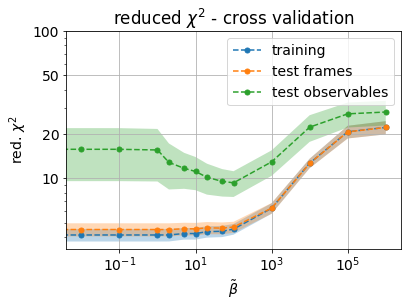

In [20]:

#font = {'family' : 'normal','weight' : 'bold','size'   : 10}
#font={'size' : 10}
#matplotlib.rc('font', **font)

plt.figure()#figsize=(8,6))
plt.rcParams['font.size'] = 14

# i=1
#s=['train_red.chi2[%i]_noUNOEs' %i,'test_red.chi2[%i]_sameobs_noUNOEs' %i,'test_red.chi2[%i]_newobs_noUNOEs' %i]#,'test_red.chi2[%i]_noUNOEs' %i]
#s=['train_red.chi2[%i]_UNOEs' %i,'test_red.chi2[%i]_sameobs_UNOEs' %i,'test_red.chi2[%i]_newobs_UNOEs' %i]#,'test_red.chi2[%i]_UNOEs' %i]
s=['train_red.chi2','test_red.chi2_sameobs','test_red.chi2_newobs']#,'test_red.chi2[%i]' %i]
#labels=['training','test, same obs.','test, new obs.']#,'test, all obs.']
labels=['training','test frames','test observables']
#s=['train_lossf','test_lossf']
#labels=['training','test']

print('beta: ',np.array(data_FFF_pivot['mean'][s[0]].columns))
for j in range(len(s)):
    w=np.array(data_FFF_pivot['mean'][s[j]])[0,:]
    print(s[j],w)
    erronmean=np.array(data_FFF_pivot['std'][s[j]])/np.sqrt(np.array(data_FFF_pivot['count'][s[j]]))
    plt.plot(data_FFF_pivot['mean'][s[j]].columns,w,'.--',label=labels[j],markersize=10)
    plt.fill_between(data_FFF_pivot['mean'][s[j]].columns,np.array(data_FFF_pivot['mean'][s[j]]-erronmean)[0,:],np.array(data_FFF_pivot['mean'][s[j]]+erronmean)[0,:],alpha=0.3)

plt.xscale('log')
#plt.xlim(left=0)
plt.yscale('log')
plt.grid()
plt.yticks(ticks=[10,20,50,100],labels=[10,20,50,100])
#plt.ylim(bottom=0.1)
#plt.ylim([10,200])

#plt.title(r'force field fitting ($\alpha,\zeta$ dihedral angles)')
plt.title(r'reduced $\chi^2$ - cross validation')
plt.xlabel(r'$\tilde{\beta}$')
plt.ylabel(r'red. $\chi^2$')
plt.legend()

beta:  [0.e+00 1.e-02 1.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02
 1.e+03 1.e+04 1.e+05 1.e+06]
train_red.chi2[0]_UNOEs [8.4477591  8.44773757 8.44912895 8.42589532 8.41598655 8.3074574
 8.16465693 8.07350002 7.36363267 6.71545059 2.54046989 2.18356669
 4.14861962 4.67073575]
test_red.chi2[0]_sameobs_UNOEs [8.97824297 8.97810225 8.98008333 8.95357543 8.93878686 8.79377224
 8.63116162 8.47236344 7.69207109 6.973697   2.58359496 2.23636518
 4.24944089 4.78288445]
test_red.chi2[0]_newobs_UNOEs [17.26669457 17.2673179  17.27957607 17.23838231 17.18124192 17.19985473
 16.86835157 14.10142615 12.50609474  9.43520442  3.42203745  3.95634545
  5.65256659  5.99696373]
beta:  [0.e+00 1.e-02 1.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02
 1.e+03 1.e+04 1.e+05 1.e+06]
train_red.chi2[0]_noUNOEs [3.45171897 3.45153016 3.45159723 3.44650877 3.40376067 3.36537798
 3.33615416 3.24733916 3.13220848 2.98106558 2.3142766  2.01599227
 1.90095114 1.88434992]
test_red.chi2[0]_sameobs_noU

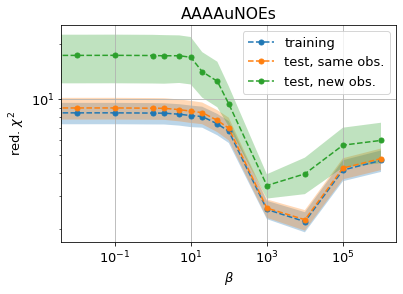

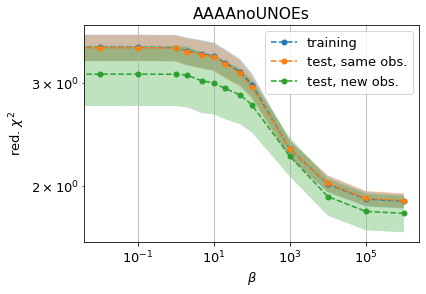

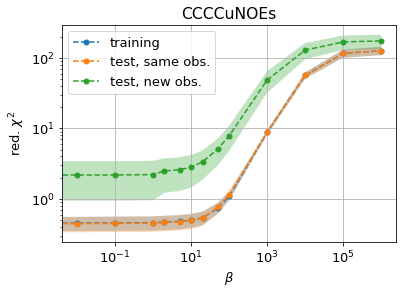

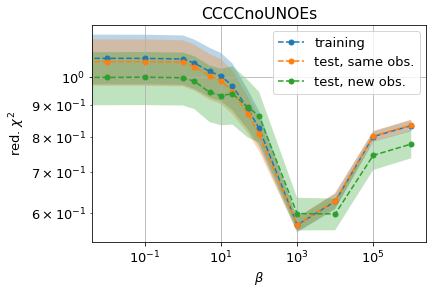

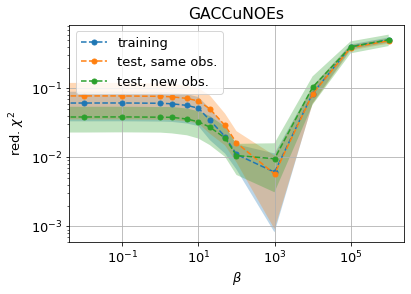

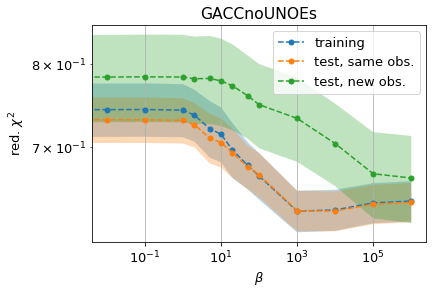

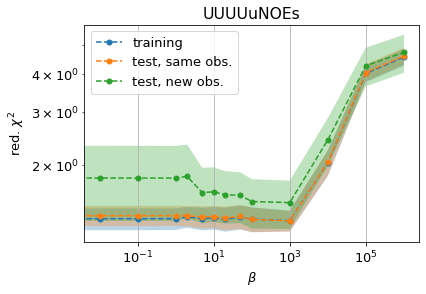

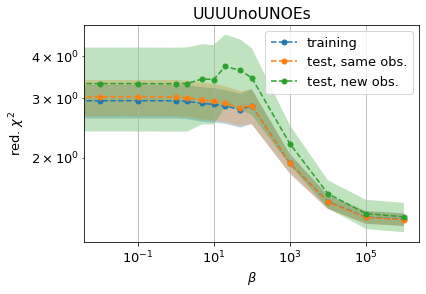

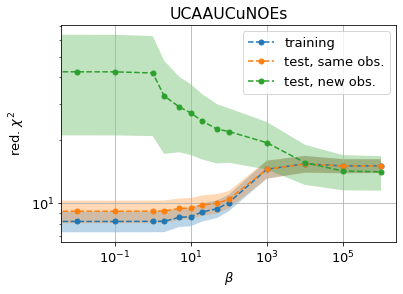

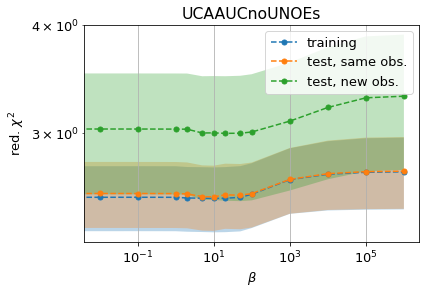

In [21]:
for i in range(len(Sequences)):
#font = {'family' : 'normal','weight' : 'bold','size'   : 10}
#font={'size' : 10}
#matplotlib.rc('font', **font)

    for s_leg in ['uNOEs','noUNOEs']:
        if s_leg=='uNOEs': s=['train_red.chi2[%i]_UNOEs' %i,'test_red.chi2[%i]_sameobs_UNOEs' %i,'test_red.chi2[%i]_newobs_UNOEs' %i]#,['test_red.chi2[%i]_noUNOEs' %i]]
        elif s_leg=='noUNOEs': s=['train_red.chi2[%i]_noUNOEs' %i,'test_red.chi2[%i]_sameobs_noUNOEs' %i,'test_red.chi2[%i]_newobs_noUNOEs' %i]
    #s=['train_red.chi2[%i]_UNOEs' %i,'test_red.chi2[%i]_sameobs_UNOEs' %i,'test_red.chi2[%i]_newobs_UNOEs' %i]#,'test_red.chi2[%i]_UNOEs' %i]

        plt.figure()#figsize=(8,6))
        plt.rcParams['font.size'] = 13

        #s=['train_red.chi2[%i]_noUNOEs' %i,'test_red.chi2[%i]_sameobs_noUNOEs' %i,'test_red.chi2[%i]_newobs_noUNOEs' %i]#,'test_red.chi2[%i]_noUNOEs' %i]
        #s=['train_red.chi2[%i]_UNOEs' %i,'test_red.chi2[%i]_sameobs_UNOEs' %i,'test_red.chi2[%i]_newobs_UNOEs' %i]#,'test_red.chi2[%i]_UNOEs' %i]
        #s=['train_red.chi2','test_red.chi2_sameobs','test_red.chi2_newobs']#,'test_red.chi2[%i]' %i]
        labels=['training','test, same obs.','test, new obs.']#,'test, all obs.']

        print('beta: ',np.array(data_FFF_pivot['mean'][s[0]].columns))
        for j in range(len(s)):
            w=np.array(data_FFF_pivot['mean'][s[j]])[0,:]
            print(s[j],w)
            erronmean=np.array(data_FFF_pivot['std'][s[j]])/np.sqrt(np.array(data_FFF_pivot['count'][s[j]]))
            plt.plot(data_FFF_pivot['mean'][s[j]].columns,w,'.--',label=labels[j],markersize=10)
            plt.fill_between(data_FFF_pivot['mean'][s[j]].columns,np.array(data_FFF_pivot['mean'][s[j]]-erronmean)[0,:],np.array(data_FFF_pivot['mean'][s[j]]+erronmean)[0,:],alpha=0.3)

        plt.xscale('log')
        plt.yscale('log')
        #plt.ylim(bottom=0.1)
        #plt.ylim([0.01,10])
        plt.grid()
        plt.title(Sequences[i]+s_leg)#r'force field fitting')
        plt.xlabel(r'$\beta$')
        plt.ylabel(r'red. $\chi^2$')
        plt.legend()

### c. force field fitting + ensemble refinement

In [22]:
userdoc_ERFF=userdoc_FFF

In [23]:
def read_results_ERFFF(Sequences,if_uNOEs,userdoc_ERFF,n_exp,nobs_test):

    # 1. read csv
    cols=pandas.read_csv(os.path.join(userdoc_ERFF,"table"),header=0,nrows=0).columns
    data_ERFF=pandas.read_csv(os.path.join(userdoc_ERFF,"table"),header=0,usecols=range(len(cols)-1))

    # 2. drop some columns, rename others consistently
    data_ERFF=data_ERFF.drop(columns=data_ERFF.columns[data_ERFF.columns.str.startswith('Unnamed:')])
    #data_ERFF=data_ERFF[data_ERFF['seed']<9]
    #data_ERFF=data_ERFF.drop(columns=['time','niter','nfail'])

    if not if_uNOEs:
        data_ERFF.rename(columns={'redchi2[%i][0]' %i: 'train_red.chi2[%i]' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2_1[%i][0]' %i: 'test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2_2[%i][0]' %i: 'test_red.chi2[%i]_sameobs' %i for i in range(len(Sequences))}, inplace=True)
    else:
        data_ERFF.rename(columns={'redchi2[%i][0]' %i: 'train_red.chi2[%i]_noUNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2_1[%i][0]' %i: 'test_red.chi2[%i]_newobs_noUNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2_2[%i][0]' %i: 'test_red.chi2[%i]_sameobs_noUNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2[%i][1]' %i: 'train_red.chi2[%i]_UNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2_1[%i][1]' %i: 'test_red.chi2[%i]_newobs_UNOEs' %i for i in range(len(Sequences))}, inplace=True)
        data_ERFF.rename(columns={'redchi2_2[%i][1]' %i: 'test_red.chi2[%i]_sameobs_UNOEs' %i for i in range(len(Sequences))}, inplace=True)

    # 3. compute totals
    filter_col = [col for col in data_ERFF if col.startswith('train_Srel[')]
    data_ERFF['train_Srel']=np.sum(data_ERFF[filter_col],axis=1)
    filter_col = [col for col in data_ERFF if col.startswith('train_Srel_alpha')]
    data_ERFF['train_Srel_alpha']=np.sum(data_ERFF[filter_col],axis=1)
    filter_col = [col for col in data_ERFF if col.startswith('train_Srel_beta')]
    data_ERFF['train_Srel_beta']=np.sum(data_ERFF[filter_col],axis=1)
    filter_col = [col for col in data_ERFF if col.startswith('test_Srel[')]
    data_ERFF['test_Srel']=np.sum(data_ERFF[filter_col],axis=1)
    filter_col = [col for col in data_ERFF if col.startswith('test_Srel_alpha')]
    data_ERFF['test_Srel_alpha']=np.sum(data_ERFF[filter_col],axis=1)
    filter_col = [col for col in data_ERFF if col.startswith('test_Srel_beta')]
    data_ERFF['test_Srel_beta']=np.sum(data_ERFF[filter_col],axis=1)

    # 4. compute total reduced chi2
    if not if_uNOEs:
        filter_col = [col for col in data_ERFF if col.startswith('train_red.chi2')]
        data_ERFF['train_red.chi2']=np.sum(data_ERFF[filter_col]*(n_exp[:,0]-nobs_test[:,0]),axis=1)/(np.sum(n_exp[:,0])-np.sum(nobs_test[:,0]))

        filter_col = ['test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))]
        data_ERFF['test_red.chi2_newobs']=np.sum(data_ERFF[filter_col],axis=1)/len(Sequences)


        filter_col = ['test_red.chi2[%i]_sameobs' %i for i in range(len(Sequences))]
        data_ERFF['test_red.chi2_sameobs']=np.sum(data_ERFF[filter_col]*(n_exp[:,0]-nobs_test[:,0]),axis=1)/(np.sum(n_exp[:,0])-np.sum(nobs_test[:,0]))

        data_ERFF['test_red.chi2']=(data_ERFF['test_red.chi2_newobs']*np.sum(nobs_test[:,0])+data_ERFF['test_red.chi2_sameobs']*(np.sum(n_exp[:,0])-np.sum(nobs_test[:,0])))/np.sum(n_exp[:,0])

    else:
        filter_col1 = ['train_red.chi2[%i]_noUNOEs' %i for i in range(len(Sequences))]
        filter_col2 = ['train_red.chi2[%i]_UNOEs' %i for i in range(len(Sequences))]
        data_ERFF['train_red.chi2']=(np.sum(data_ERFF[filter_col1]*(n_exp[:,0]-nobs_test[:,0]),axis=1)+np.sum(data_ERFF[filter_col2]*(n_exp[:,1]-nobs_test[:,1]),axis=1))/(np.sum(n_exp)-np.sum(nobs_test))

        filter_col1 = ['test_red.chi2[%i]_newobs_noUNOEs' %i for i in range(len(Sequences))]
        filter_col2 = ['test_red.chi2[%i]_newobs_UNOEs' %i for i in range(len(Sequences))]
        data_ERFF['test_red.chi2_newobs']=(np.sum(data_ERFF[filter_col1]*nobs_test[:,0],axis=1)+np.sum(data_ERFF[filter_col2]*nobs_test[:,1],axis=1))/(np.sum(nobs_test))

        filter_col1 = ['test_red.chi2[%i]_sameobs_noUNOEs' %i for i in range(len(Sequences))]
        filter_col2 = ['test_red.chi2[%i]_sameobs_UNOEs' %i for i in range(len(Sequences))]
        data_ERFF['test_red.chi2_sameobs']=(np.sum(data_ERFF[filter_col1]*(n_exp[:,0]-nobs_test[:,0]),axis=1)+np.sum(data_ERFF[filter_col2]*(n_exp[:,1]-nobs_test[:,1]),axis=1))/(np.sum(n_exp)-np.sum(nobs_test))

        data_ERFF['test_red.chi2']=(data_ERFF['test_red.chi2_newobs']*np.sum(nobs_test)+data_ERFF['test_red.chi2_sameobs']*(np.sum(n_exp)-np.sum(nobs_test)))/np.sum(n_exp)

    # 5. drop some columns
    data_ERFF=data_ERFF.drop(columns=data_ERFF.columns[data_ERFF.columns.str.contains('kish')])
    data_ERFF=data_ERFF.drop(columns=data_ERFF.columns[data_ERFF.columns.str.contains('errorf')])

    return data_ERFF

In [24]:
data_ERFF=read_results_ERFFF(Sequences,if_uNOEs,userdoc_ERFF,n_exp,nobs_test)
data_ERFF=data_ERFF.drop_duplicates(subset=['alpha','beta','seed'])

In [25]:
alphas=[0.01,0.1,1,2,5,10,20,50,100,1e3,1e4,1e5,1e6]
betas=[0]+alphas

missing=[]
for i_seed in range(1,21):
    for alpha in alphas:
        this_betas=data_ERFF[(data_ERFF['seed']==i_seed) & (data_ERFF['alpha']==alpha)]['beta'].tolist()
        res=[item for item in betas if item not in this_betas]
        for res_j in res: missing.append([i_seed,alpha,res_j])

print(len(missing))
missing

0


[]

### 2. pivot
but first consider at once the three different tables

In [26]:
alphas=np.unique(data_ERFF['alpha'])
betas=np.unique(data_ERFF['beta'])

print('alphas: ',alphas)
print('betas: ',betas)

alphas:  [0.e+00 1.e-02 1.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02
 1.e+03 1.e+04 1.e+05 1.e+06    inf]
betas:  [0.e+00 1.e-02 1.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02
 1.e+03 1.e+04 1.e+05 1.e+06    inf]


concatenate all_ER, all_FF, all_ERFF
- same values of alpha and beta
- keep infty only once

In [27]:
s='train_red.chi2'
#s='test_red.chi2_newobs'
#s='test_red.chi2_sameobs'
print('original ensemble: comparison ER and ER+FFF')
print('averages')
print('%s at alpha,beta infinite (ER): ' %s,np.array(data_ER_pivot['mean'][s].loc[np.inf])[0])
print('%s at alpha,beta infinite (ER+FFF): ' %s,data_ERFF.pivot_table(index='alpha',columns='beta',aggfunc=['first','mean','std','count'])['mean'][s].loc[np.inf,np.inf])

i_seed=1
print('seed: ',i_seed)
print('%s at alpha,beta infinite (ER): ' %s,np.array(data_ER[(data_ER['seed']==i_seed) & (data_ER['alpha']==np.inf)][s])[0])
print('%s at alpha,beta infinite (ER+FFF): ' %s,np.array(data_ERFF[(data_ERFF['seed']==i_seed) & (data_ERFF['alpha']==np.inf) & (data_ERFF['beta']==np.inf)][s])[0])

print('original ensemble: comparison ER and ER+FFF')
print('averages')
print('training loss function at alpha,beta infinite (ER): ',np.array(data_ER_pivot['mean']['train_lossf'].loc[np.inf])[0])
print('training loss function at alpha,beta infinite (ER+FFF): ',data_ERFF.pivot_table(index='alpha',columns='beta',aggfunc=['first','mean','std','count'])['mean']['train_lossf'].loc[np.inf,np.inf])

i_seed=1
print('seed: ',i_seed)
print('training loss function at alpha,beta infinite (ER): ',np.array(data_ER[(data_ER['seed']==i_seed) & (data_ER['alpha']==np.inf)]['train_lossf'])[0])
print('training loss function at alpha,beta infinite (ER+FFF): ',np.array(data_ERFF[(data_ERFF['seed']==i_seed) & (data_ERFF['alpha']==np.inf) & (data_ERFF['beta']==np.inf)]['train_lossf'])[0])


original ensemble: comparison ER and ER+FFF
averages
train_red.chi2 at alpha,beta infinite (ER):  22.36710212954124
train_red.chi2 at alpha,beta infinite (ER+FFF):  22.36710212919146
seed:  1
train_red.chi2 at alpha,beta infinite (ER):  12.412821486612666
train_red.chi2 at alpha,beta infinite (ER+FFF):  12.412821487334318
original ensemble: comparison ER and ER+FFF
averages
training loss function at alpha,beta infinite (ER):  15187.262345956004
training loss function at alpha,beta infinite (ER+FFF):  15187.2623459545
seed:  1
training loss function at alpha,beta infinite (ER):  8428.30578939
training loss function at alpha,beta infinite (ER+FFF):  8428.3057894


In [28]:
i_seed='all'#all
if i_seed=='all': s1='mean'
#s1='count'
#s='train_Srel'#lpha'
#s='test_Srel[0]'
s='test_red.chi2_newobs'
#s='train_red.chi2'#'train_Srel'#'train_lossf'#test_red.chi2_newobs'
#s='train_lossf'
#s='train_Srel_beta'
#s='test_lossf'

def build_junction():

    if i_seed=='all':
        a0=data_ERFF.pivot_table(index='alpha',columns='beta',aggfunc=['first','mean','std','count'])[s1][s]
        a=pandas.concat([a0.iloc[:-1,:-1],data_FFF_pivot[s1][s]])
        a1=data_ER_pivot[s1][s].iloc[:-1]
        a2=a0.loc[np.infty,np.infty]
    else:
        a=pandas.concat([data_ERFF[data_ERFF['seed']==i_seed].pivot(index='alpha',columns='beta')[s].iloc[:-1,:-1],data_FFF[data_FFF['seed']==i_seed].pivot(index='alpha',columns='beta')[s]])
        a1=data_ER[data_ER['seed']==i_seed].pivot(index='alpha',columns='beta')[s].iloc[:-1]
        a2=data_ERFF[data_ERFF['seed']==i_seed].pivot(index='alpha',columns='beta')[s].loc[np.infty,np.infty]
    
    a1=a1.append(pandas.DataFrame([a2],index=[np.infty],columns=a1.columns))
    b=pandas.concat([a.T,a1.T])
    b.columns.name='alpha'
    if i_seed=='all' and s1=='count': b=b.astype('Int32')

    return b

b=build_junction()
#print('min: ',np.where(b==np.min(np.min(b))))
b=b.iloc[:,1:] # exclude alpha=0 (first column)
print(np.min(np.min(b)))
b

5.696447346111492


alpha,0.01,0.10,1.00,2.00,5.00,10.00,20.00,50.00,100.00,1000.00,10000.00,100000.00,1000000.00,inf
beta,,,,,,,,,,,,,,
0.00,293.636022,178.047723,105.993007,52.161497,6.260355,5.718424,5.736670,6.047073,9.467909,11.266481,15.851417,15.710593,15.735869,15.774700
0.01,299.644907,180.621501,106.288254,51.085865,6.341613,5.771411,5.696447,6.047517,9.483476,11.180578,15.826171,15.695883,15.746466,15.763381
0.10,300.595710,191.765646,105.943204,52.811229,6.603580,6.019164,5.806888,6.109881,9.212903,10.803022,15.788097,15.671007,15.722862,15.759651
1.00,296.711627,192.344869,111.586203,56.946084,8.146928,7.578785,7.027205,6.640623,7.852744,9.736863,15.397217,15.736537,15.431269,15.599465
2.00,296.997684,192.276041,112.371746,57.522707,8.798382,8.522803,7.818380,7.114632,7.347978,9.308626,12.678545,15.382267,15.099643,12.838704
5.00,295.019511,192.202041,113.489542,57.380631,9.445605,9.651842,9.157936,8.158461,7.688981,8.900024,11.053663,11.636772,11.700087,11.709640
10.00,294.053043,192.307967,113.825151,57.147653,9.724434,10.205716,9.991829,9.113508,8.463297,8.617143,10.529476,10.932183,11.104317,11.147477
20.00,295.212802,192.289624,114.213241,57.138335,9.898725,10.564280,10.552214,9.932919,9.349410,8.656410,9.996754,10.443840,10.490859,10.172923
50.00,296.164815,192.268806,114.319946,57.001660,10.014035,10.810565,10.975501,10.713019,10.356938,9.386667,9.295549,9.552992,9.561762,9.550768


In [29]:
i_seed='all'
s1='std'

error=build_junction().iloc[:,1:]/np.sqrt(20)
error
#error.to_pickle('results/conclusions/alphaonly/redchi2_error')

alpha,0.01,0.10,1.00,2.00,5.00,10.00,20.00,50.00,100.00,1000.00,10000.00,100000.00,1000000.00,inf
beta,,,,,,,,,,,,,,
0.00,89.886848,67.042879,63.081356,36.003604,1.083834,0.982406,1.036062,1.312549,3.801243,4.544295,6.241894,6.057358,6.048048,6.190431
0.01,93.150429,67.552692,63.111175,35.948350,1.084959,0.983751,1.023057,1.318386,3.793052,4.468606,6.224867,6.045758,6.049889,6.181958
0.10,93.526560,71.029989,62.954295,37.122019,1.163565,1.037103,1.047655,1.331221,3.541723,4.160794,6.201793,6.029987,6.034901,6.179217
1.00,91.571036,71.091571,62.275911,39.680195,1.476125,1.370960,1.332699,1.400179,2.396203,3.328048,5.930223,5.824031,5.845243,6.069741
2.00,91.965739,71.079770,62.106095,39.666474,1.572376,1.547219,1.458885,1.452784,1.802747,2.995088,4.295101,5.588531,5.620887,4.426683
5.00,90.591235,71.090996,62.052070,39.033228,1.669780,1.726019,1.671368,1.582787,1.611886,2.598173,3.005463,3.111412,3.116731,3.211156
10.00,89.960557,71.084691,61.889478,38.487813,1.708082,1.813782,1.801423,1.714019,1.664907,2.210680,2.623878,2.703568,2.707730,2.828940
20.00,90.645394,71.087796,61.979292,38.342024,1.729366,1.869849,1.890789,1.829129,1.768998,1.916326,2.285037,2.376337,2.408900,2.413281
50.00,90.943912,71.078368,61.862030,38.085132,1.744657,1.910945,1.965391,1.964318,1.933308,1.847624,1.969288,2.018246,2.022138,2.019148


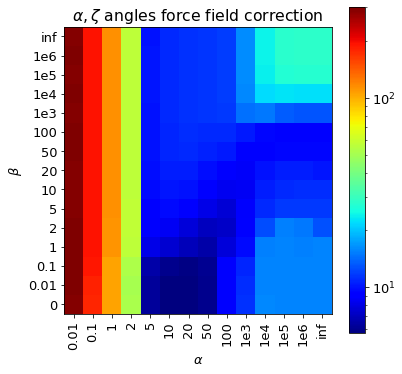

In [30]:
from matplotlib.colors import LogNorm

if b.columns.name=='alpha': alphas=b.columns
if b.index.name=='beta': betas=b.index

X,Y = np.meshgrid(alphas,betas)

#s='test_red.chi2'#_sameobs'
#s='train_red.chi2'
#a=np.array(data_ERFF['mean'][s])
plt.figure(figsize=(6,6))
plt.rcParams['font.size'] = 13
#plt.imshow(b,cmap='jet',interpolation='none')
b_show=b.iloc[::-1]

#np.array2string(np.array(b_show.columns))
cols=['0.01','0.1','1','2','5','10','20','50','100','1e3','1e4','1e5','1e6','inf']
rows=(['0']+cols)[::-1]
rows

plt.imshow(b_show,cmap='jet',interpolation='none',norm=LogNorm(vmin=np.nanmin(np.array(b_show)),vmax=np.nanmax(np.array(b_show)))) # b or np.log(b)
#plt.imshow(b_show,cmap='jet',interpolation='none')#,vmin=np.min(np.array(b_show)),vmax=np.max(np.array(b_show)))
#plt.imshow(np.log(np.array(b).T),cmap='jet',interpolation='none') # interpolation='lanczos'
plt.colorbar()
plt.xlabel(r'$\alpha$')
plt.xticks(range(len(alphas)),cols,rotation=90) # b_show.columns
plt.ylabel(r'$\beta$')
plt.yticks(range(len(betas)),rows)#b_show.index)
plt.title(r'$\alpha,\zeta$ angles force field correction')
#plt.title(r'red. $\chi^2$, trainingest (new observables)')#new observables')
#plt.title(r'-$S_{rel}[P|P_0]$ training')
plt.show()

### 3. compare results from different force-field correction terms

In [47]:
df_alphazeta=b

In [37]:
df_chi=b

In [29]:
df_alphaonly=b

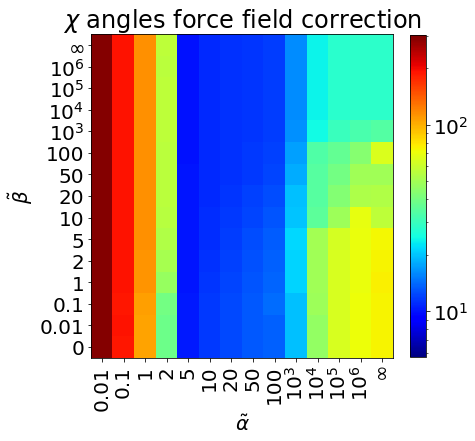

In [53]:
all_data = np.concatenate([df_alphazeta,df_chi,df_alphaonly])#, P.biased, P.rewER, P.rewFFF, P.rewERFFF, P.rewERFFF2])

b=df_chi

if b.columns.name=='alpha': alphas=b.columns
if b.index.name=='beta': betas=b.index

X,Y = np.meshgrid(alphas,betas)

#s='test_red.chi2'#_sameobs'
#s='train_red.chi2'
#a=np.array(data_ERFF['mean'][s])
plt.figure(figsize=(6,6))
plt.rcParams['font.size'] = 20
#plt.imshow(b,cmap='jet',interpolation='none')
b_show=b.iloc[::-1]

#np.array2string(np.array(b_show.columns))
cols=['0.01','0.1','1','2','5','10','20','50','100',r'$10^3$',r'$10^4$',r'$10^5$',r'$10^6$',r'$\infty$']
rows=(['0']+cols)[::-1]
rows

im=plt.imshow(b_show,cmap='jet',interpolation='none',norm=LogNorm(vmin=np.nanmin(np.array(all_data)),vmax=np.nanmax(np.array(all_data)))) # b or np.log(b)
#plt.imshow(b_show,cmap='jet',interpolation='none')#,vmin=np.min(np.array(b_show)),vmax=np.max(np.array(b_show)))
#plt.imshow(np.log(np.array(b).T),cmap='jet',interpolation='none') # interpolation='lanczos'
plt.xlabel(r'$\tilde{\alpha}$')
plt.xticks(range(len(alphas)),cols,rotation=90) # b_show.columns
plt.ylabel(r'$\tilde{\beta}$')
plt.yticks(range(len(betas)),rows)#b_show.index)
plt.title(r'$\chi$ angles force field correction')
plt.colorbar(im,fraction=0.048)#, pad=0.04)
#plt.title(r'red. $\chi^2$, trainingest (new observables)')#new observables')
#plt.title(r'-$S_{rel}[P|P_0]$ training')
plt.show()


### ... (other)

In [84]:

plt.title('%s' % title[i])
#plt.text(-8, -9, r'$D_{KL}=%s$' % Srel_value[i], fontsize = 22, bbox = dict(facecolor = 'white', alpha = 0.8))
for j in range(4): plt.text(x_lab[j], y_lab[j], r'%.2f' % np.around(pops[i][j],decimals=2), fontsize = 16)#, bbox = dict(facecolor = 'white', alpha = 0.8))
    #'%.2f' % populations.biased[1], fontsize = 22, bbox = dict(facecolor = 'white', alpha = 0.8))
    plot=+Ps[i]
    plot[plot<1e-6]=np.nan
    #plt.scatter(X_grid,Y_grid,c=plot,cmap='Reds',norm=norm)#,interpolation='none') # interpolation='lanczos'
    plt.contourf(X_grid,Y_grid,plot,cmap='Reds',norm=norm)

    plt.plot([-upto,upto],[avs.exp[1],avs.exp[1]],'--k')
    plt.plot([avs.exp[0],avs.exp[0]],[-upto,upto],'--k')
    if not (title[i]=='ground truth'):
        plt.plot([-upto,upto],[avs_values[i][1],avs_values[i][1]],'--b')
        plt.plot([avs_values[i][0],avs_values[i][0]],[-upto,upto],'--b')

    #plt.colorbar() # arbitrary units (what matters are the ratios)
    plt.xlim([-upto,upto])
    plt.ylim([-upto,upto])
    if i>=N-2: plt.xlabel('x')
    if np.mod(i,2)==0: plt.ylabel('y')
    plt.yticks([-10,-5,0,5,10])

In [33]:
alphas=np.array(b.columns)

In [30]:
row_Srel_alpha=np.array(b.loc[10,:])

In [27]:
row_redchi2=np.array(b.loc[10,:])

In [25]:
row_lossf=np.array(b.loc[10,:])

In [44]:
alphas[-1]=alphas[-2]*10

In [47]:
(row_lossf[1:]+row_Srel_alpha[1:]*alphas[1:])/row_redchi2[1:]

array([ 120.99288733,  120.73511644,  121.70763815,  122.14007222,
        122.04045261,  122.71198917,  125.37967122,  134.59547587,
        150.08873401,  330.22330081,  823.08288301, 1213.70997506,
       1308.01001207,  694.35772079])

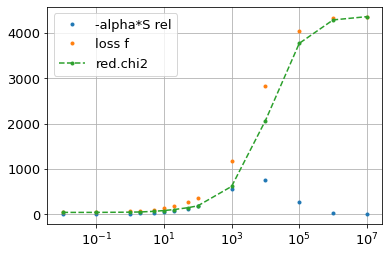

In [71]:
plt.plot(alphas[1:],-row_Srel_alpha[1:]*alphas[1:],'.',label='-alpha*S rel')
plt.plot(alphas[1:],row_lossf[1:],'.',label='loss f')
plt.plot(alphas[1:],row_lossf[1:]+row_Srel_alpha[1:]*alphas[1:],'.--',label='red.chi2')
plt.xscale('log')
plt.grid()
plt.legend()



In [290]:
v=[]
for i in range(len(Sequences)):
    print(i)
    v.append(np.array(crossv['mean'][s[i]])*(n_exp[i,0]-nobs_test[0]))
w=np.sum(v,axis=0)/np.sum(n_exp[:,0]-nobs_test[0])
w.shape

0
1
2
3
4


(13, 14)

In [293]:
# for test_red.chi2[%i]_newobs, since same number of test observables (no uNOEs)
s=['test_red.chi2[%i]_newobs' %i for i in range(len(Sequences))]

test_redchi2_newobs=crossv['mean'][s[0]]
test_redchi2_newobs_error=crossv['std'][s[0]]
for i in range(1,len(Sequences)):
    test_redchi2_newobs+=crossv['mean'][s[i]]#+crossv['mean'][s[2]]+crossv['mean'][s[3]]+crossv['mean'][s[4]])/len(Sequences)
    test_redchi2_newobs_error+=crossv['std'][s[i]]#+crossv['std'][s[1]]+crossv['std'][s[2]]+crossv['std'][s[3]]+crossv['std'][s[4]])/(len(Sequences)*np.sqrt(length))

# for test_red.chi2[%i]_sameobs and train_red.chi2[%i]
s=['test_red.chi2[%i]_sameobs' %i for i in range(len(Sequences))]
v=[]
for i in range(len(Sequences)):
    print(i)
    v.append(np.array(crossv['mean'][s[i]])*(n_exp[i,0]-nobs_test[0]))
test_redchi2_sameobs=np.sum(v,axis=0)/np.sum(n_exp[:,0]-nobs_test[0])
del v

#view=(crossv['std'][s[0]]+crossv['std'][s[1]]+crossv['std'][s[2]]+crossv['std'][s[3]]+crossv['std'][s[4]])/(len(Sequences)*np.sqrt(length))

0
1
2
3
4


beta,0.01,0.10,1.00,2.00,5.00,10.00,20.00,50.00,100.00,1000.00,10000.00,100000.00,1000000.00,inf
alpha,,,,,,,,,,,,,,
0.01,23.329977,28.789027,18.968973,16.517693,14.273920,17.731754,10.267406,31.956909,9.617135,13.824385,14.076708,14.270228,16.614505,16.808987
0.10,12.017268,22.837479,9.019427,23.783911,9.338049,15.035546,8.613017,5.872197,10.590586,6.452375,11.377558,7.419154,13.111288,9.996023
1.00,3.165830,2.721806,2.702484,2.387737,2.676827,2.416586,2.177490,2.412133,2.517486,2.634916,2.231522,2.589451,2.118803,2.313719
2.00,2.078722,1.871674,1.951165,1.463897,1.663101,2.177745,1.977885,2.009547,1.942590,1.746783,1.758951,1.689977,1.747216,1.824159
5.00,1.249318,1.348719,1.221992,1.314870,1.264808,1.346407,1.466529,1.440768,1.221663,1.283146,1.266991,1.301314,1.172512,1.317969
10.00,1.257906,1.344867,1.233914,1.191839,1.176832,1.225444,1.218340,1.085625,1.257532,1.206182,1.066330,1.202166,1.189199,1.192325
20.00,1.145764,1.223432,1.216423,1.164163,1.163410,1.196149,1.273971,1.240588,1.034375,1.082772,1.112915,1.056202,1.126543,1.142072
50.00,1.115690,1.118430,1.101494,1.178198,1.160880,1.157620,1.209164,1.164067,1.108800,1.169618,1.220766,1.219010,1.156152,1.136495
100.00,1.076195,1.043577,0.995133,1.067777,1.176808,1.159106,1.151308,1.118228,1.075592,1.156030,1.124209,1.156930,1.125728,1.150045


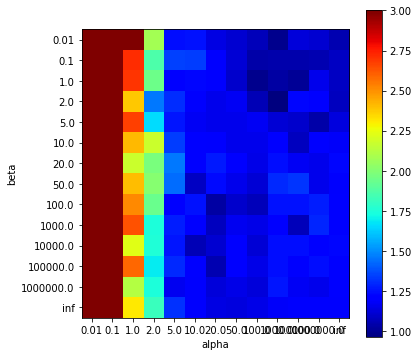

In [310]:
X,Y = np.meshgrid(alphas,betas)

plt.figure(figsize=(6,6))
plt.imshow(test_redchi2_newobs.T,vmax=3,cmap='jet',interpolation='none') # interpolation='lanczos'
plt.colorbar()
plt.xlabel('alpha')
plt.xticks(range(len(alphas)),alphas)
plt.ylabel('beta')
plt.yticks(range(len(betas)),betas)
plt.show()

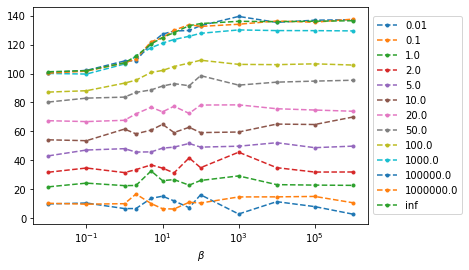

In [128]:
for i in range(len(alphas)):
    plt.plot(betas,np.array(view[(view.index.get_level_values('alpha') == alphas[i])])[0],'.--',label=alphas[i])

plt.xlabel(r'$\beta$')
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

watch out! value of the loss function at alpha, beta infinite

In [ ]:
data_ER=[]

for i in range(len(Sequences)):
    if if_uNOEs: range_usecols=18
    else: range_usecols=15
    data_ER.append(pandas.read_csv(os.path.join(userdoc_ER,"%s_table" % Sequences[i]),header=0,usecols=range(range_usecols)))
    if common_seed is not None: data_ER[i]=data_ER[i][data_ER[i]['seed']<=common_seed] # common seeds
    data_ER[i]=data_ER[i].drop(columns=data_ER[i].columns[data_ER[i].columns.str.startswith('Unnamed:')])
    data_ER[i]=data_ER[i].drop(data_ER[i][data_ER[i]['alpha']=='alpha'].index)#,inplace=True)
    data_ER[i]=data_ER[i].sort_values(by=['alpha'],ignore_index=True)


In [ ]:
df=pandas.concat(data_ER,axis=1)
df['train_lossf']

,train_lossf,train_lossf,train_lossf,train_lossf,train_lossf
0,1.572933,0.286294,0.237367,0.138304,48.111496
1,2.352561,0.516985,0.528894,0.537174,47.585361
2,2.166044,0.514062,0.373266,0.446136,45.813978
3,1.949517,0.306274,0.547111,0.246246,23.788069
4,0.662379,0.243606,0.670732,0.520843,28.930637
...,...,...,...,...,...
135,35739.454991,4666.779438,65.551361,433.020563,4155.760077
136,45893.225808,16743.849865,56.495251,530.008336,4016.041599
137,27271.796359,15703.058675,74.086716,503.064851,3988.272685
138,18936.345690,12658.322851,53.933394,248.536645,4320.265338


In [113]:
df2=df[['alpha','seed','errorf[0][0]','errorf[0][1]']]
df2.columns=['alpha[%i]' %i for i in range(len(Sequences))]+['seed[%i]' %i for i in range(len(Sequences))]+['errorf[%i][0]' %i for i in range(len(Sequences))]+['errorf[%i][1]' %i for i in range(len(Sequences))]
df2=df2.drop(columns=['alpha[%i]' %i for i in range(1,len(Sequences))]+['seed[%i]' %i for i in range(1,len(Sequences))])

s=['errorf[%i][0]' %i for i in range(len(Sequences))]+['errorf[%i][1]' %i for i in range(len(Sequences))]
df2[s]=df2[s]/nobs_test.T.flatten()
df2[df2['alpha[0]']==np.inf][['seed[0]']+s]

,seed[0],errorf[0][0],errorf[1][0],errorf[2][0],errorf[3][0],errorf[4][0],errorf[0][1],errorf[1][1],errorf[2][1],errorf[3][1],errorf[4][1]
130,9.0,1.935040,0.969799,0.602892,1.073736,4.083727,167.447760,1.910796,0.481666,2.935785,15.752542
131,8.0,1.971884,1.054351,0.913746,1.882390,1.632870,254.856297,196.614243,0.000421,5.444553,23.854394
132,7.0,0.899608,0.914813,0.827933,1.105258,4.283717,331.322939,170.977208,0.699649,3.618603,24.512761
133,6.0,1.915815,0.810545,0.799483,1.195527,3.951388,382.598989,210.482140,1.018584,3.499034,15.052411
134,5.0,0.825183,0.902269,0.647274,1.494040,4.438697,382.216813,42.040107,0.542420,3.507481,10.499321
135,4.0,1.877810,0.827880,0.751912,1.608647,3.836431,315.946007,62.885586,0.631078,4.905107,23.200177
136,3.0,2.022092,0.947782,0.868841,1.611276,4.206613,405.776849,226.063316,0.505379,6.045830,22.331245
137,2.0,1.816919,1.162554,0.751336,1.833598,1.443789,241.021752,211.952133,0.730426,5.702693,22.663881
138,10.0,1.964027,1.025382,0.486349,1.351907,4.049467,167.230665,170.836713,0.542304,2.764913,24.107654
139,1.0,1.767773,1.002492,0.734511,1.507033,4.122636,345.717117,45.278601,0.764874,6.977989,19.697945


In [ ]:
np.sum(df[['errorf[0][0]','errorf[0][1]']].iloc[-1,:])#[df['alpha']==np.infty]

46708.28635555

In [101]:
filter_col=['seed']+[col for col in data_ERFF if col.startswith('train_red.chi2[')]
data_ERFF[data_ERFF['alpha']==np.inf][filter_col]

,seed,train_red.chi2[0]_UNOEs,train_red.chi2[0]_noUNOEs,train_red.chi2[1]_UNOEs,train_red.chi2[1]_noUNOEs,train_red.chi2[2]_UNOEs,train_red.chi2[2]_noUNOEs,train_red.chi2[3]_UNOEs,train_red.chi2[3]_noUNOEs,train_red.chi2[4]_UNOEs,train_red.chi2[4]_noUNOEs
0,1.0,1.849749,6.966898,0.867020,38.960656,0.648098,0.661097,1.255861,5.991203,3.600048,16.842469
2,10.0,2.032775,7.154600,0.886817,146.999032,0.429132,0.468725,1.126589,2.373915,3.536155,20.612933
4,2.0,2.142398,8.012996,1.005452,182.377416,0.662944,0.631323,1.527998,4.896251,1.260773,19.378453
6,3.0,2.462495,7.034666,0.819703,194.519597,0.766624,0.436810,1.342730,5.190864,3.673380,19.094037
8,4.0,1.566107,0.460165,0.716004,54.110853,0.663452,0.545454,1.340539,4.211455,3.350123,19.837006
10,5.0,1.839086,6.036614,0.780341,36.174046,0.571124,0.468825,1.245034,3.011474,3.876045,8.977307
12,6.0,1.886819,5.782252,0.701012,181.112539,0.705426,0.880384,0.996273,3.004221,3.450508,12.870366
14,7.0,1.466225,0.723940,0.791189,147.119923,0.730529,0.604722,0.921048,3.106881,3.740711,20.959314
16,8.0,2.070413,7.160317,0.911871,169.179697,0.806246,0.000363,1.568658,4.674616,1.425886,20.396386
18,9.0,1.850755,1.613292,0.838745,1.644173,0.531964,0.416314,0.894780,2.520624,3.566071,13.469004


In [128]:
filter_col=['seed','alpha']+[col for col in data_ER if col.startswith('train_loss')]
data_ER[(data_ER['alpha']==np.inf) & (data_ER['seed']==1)][filter_col]

,seed,alpha,train_lossf,train_lossf[0],train_lossf[1],train_lossf[2],train_lossf[3],train_lossf[4]
139,1.0,inf,46708.286356,39101.389727,3366.656317,76.796818,608.199393,3555.244101


## Minimization on whole data set

In [ ]:
whole_data_ERFF=pandas.read_csv('Results/ERFFF_alphaonly_skip10/whole_data/table')
redchi2=(np.sum(whole_data_ERFF[['redchi2[%i][0]' %i for i in range(5)]]*n_exp[:,0],axis=1)+np.sum(whole_data_ERFF[['redchi2[%i][1]' %i for i in range(5)]]*n_exp[:,1],axis=1))/np.sum(n_exp)
print(redchi2)

0     24.151056
1    821.331846
2    821.331846
3      0.140613
dtype: float64


In [ ]:
pandas.read_csv('Results/ERFFF_alphaonly_skip10/whole_data/ff_minpars')

,alpha,beta,sinalpha,cosalpha,Unnamed: 4
0,inf,0.0,1.017502,1.857378,NaN
1,inf,100.0,0.905317,1.673959,NaN


In [ ]:
pandas.read_pickle('Results/conclusions/alphaonly/optimal_ff_coeff_FFF')['mean']

seed            mean
sinalpha    0.846034
cosalpha     1.29497
Name: mean, dtype: object

In [ ]:
a=pandas.read_pickle('Results/conclusions/alphaonly/optimal_ff_coeff_FFF')

b=pandas.DataFrame([a.loc['sinalpha'].tolist(),a.loc['cosalpha'].tolist()])
b

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.782987,0.506707,0.708813,1.023504,0.665242,0.982587,0.989991,1.030089,0.921464,0.904209,...,0.857751,0.663058,0.913547,0.832780,1.124899,0.561620,0.846034,0.905317,0.868857,0.158285
1,0.444879,1.679567,-0.848944,1.987535,1.332881,1.282168,0.988067,-0.603939,1.744565,1.620240,...,2.237777,0.559947,1.652353,1.963768,2.269806,0.570391,1.294973,1.673959,1.555103,0.846500


### 1. save output data for the whole data set in a compatible way
(i.e. same column names and possibly same $\alpha$, $\beta$ values)

1. ensemble refinement

In [ ]:
# with uNOEs
userdoc_ER = 'Results/ER_skip10/whole'
if_uNOEs=True

all_data_ER=[]

for i in range(len(Sequences)):
    all_data_ER.append(pandas.read_csv(os.path.join(userdoc_ER,"all_%s_table" % Sequences[i]),header=0))
    all_data_ER[i]=all_data_ER[i].drop(columns=all_data_ER[i].columns[all_data_ER[i].columns.str.startswith('Unnamed:')])
    all_data_ER[i]=all_data_ER[i].sort_values(by=['alpha'],ignore_index=True)

In [ ]:
all_ER=pandas.merge(all_data_ER[0], all_data_ER[1], on='alpha', suffixes=('0','1'))
all_ER2=pandas.merge(all_data_ER[2], all_data_ER[3], on='alpha', suffixes=('2','3'))
all_ER=pandas.merge(all_ER,all_ER2, on='alpha')
all_ER=pandas.merge(all_ER,all_data_ER[4],on='alpha',suffixes=('','4'))

del all_data_ER, all_ER2

all_ER.rename(columns={'train_lossf': 'train_lossf4', 'errorf[0][0]': 'errorf[0][0]4', 'train_Srel[0]': 'train_Srel[0]4'},inplace=True)
if if_uNOEs: all_ER.rename(columns={'errorf[0][1]': 'errorf[0][1]4'},inplace=True)

all_ER.columns

Index(['alpha', 'time0', 'niter0', 'nfail0', 'train_lossf0', 'train_lossf[0]0',
       'errorf[0][0]0', 'errorf[0][1]0', 'train_Srel[0]0', 'time1', 'niter1',
       'nfail1', 'train_lossf1', 'train_lossf[0]1', 'errorf[0][0]1',
       'errorf[0][1]1', 'train_Srel[0]1', 'time2', 'niter2', 'nfail2',
       'train_lossf2', 'train_lossf[0]2', 'errorf[0][0]2', 'errorf[0][1]2',
       'train_Srel[0]2', 'time3', 'niter3', 'nfail3', 'train_lossf3',
       'train_lossf[0]3', 'errorf[0][0]3', 'errorf[0][1]3', 'train_Srel[0]3',
       'time', 'niter', 'nfail', 'train_lossf4', 'train_lossf[0]',
       'errorf[0][0]4', 'errorf[0][1]4', 'train_Srel[0]4'],
      dtype='object')

In [ ]:
filter_col = [col for col in all_ER if col.startswith('time') or col.startswith('niter')]
all_ER=all_ER.drop(columns=filter_col)

In [ ]:
filter_col = [col for col in all_ER if col.startswith('nfail')]
#all_ER['n_fails']=np.sum(all_ER[filter_col],axis=1)
all_ER=all_ER.drop(columns=filter_col)

filter_col = [col for col in all_ER if col.startswith('train_lossf[')]
all_ER=all_ER.drop(columns=filter_col)

filter_col = [col for col in all_ER if col.startswith('train_lossf')]
all_ER['lossf']=np.sum(all_ER[filter_col],axis=1)

#filter_col = [col for col in all_ER if col.startswith('lossf[')]
#all_ER=all_ER.drop(all_ER[filter_col],axis=1)

all_ER.rename(columns={filter_col[i]: 'lossf[%i]' %i for i in range(len(Sequences))},inplace=True)

all_ER['beta']=np.inf

In [ ]:
filter_col = [col for col in all_ER if col.startswith('train_Srel')]
all_ER['Srel_alpha']=np.sum(all_ER[filter_col],axis=1)

all_ER.rename(columns={filter_col[i]: 'Srel_alpha[%i]' %i for i in range(len(Sequences))},inplace=True)

all_ER['Srel_beta']=0
for i in range(len(Sequences)):
    all_ER['Srel_beta[%i]' %i]=0
all_ER['Srel']=all_ER['Srel_alpha']
for i in range(len(Sequences)):
    all_ER['Srel[%i]' %i]=all_ER['Srel_alpha[%i]' %i]


In [ ]:
filter_col = [col for col in all_ER if col.startswith('errorf[0][0]')]

for i in range(len(Sequences)):
    all_ER['red.chi2[%i][0]' %i]=all_ER[filter_col[i]]*2/n_exp[i,0]

all_ER=all_ER.drop(columns=filter_col)

if if_uNOEs:
    filter_col = [col for col in all_ER if col.startswith('errorf[0][1]')]
    for i in range(len(Sequences)): all_ER['red.chi2[%i][1]' %i]=all_ER[filter_col[i]]*2/n_exp[i,1]

    all_ER=all_ER.drop(columns=filter_col)

In [ ]:
all_ER=all_ER[sorted(all_ER.columns)]
all_ER.columns

Index(['Srel', 'Srel[0]', 'Srel[1]', 'Srel[2]', 'Srel[3]', 'Srel[4]',
       'Srel_alpha', 'Srel_alpha[0]', 'Srel_alpha[1]', 'Srel_alpha[2]',
       'Srel_alpha[3]', 'Srel_alpha[4]', 'Srel_beta', 'Srel_beta[0]',
       'Srel_beta[1]', 'Srel_beta[2]', 'Srel_beta[3]', 'Srel_beta[4]', 'alpha',
       'beta', 'lossf', 'lossf[0]', 'lossf[1]', 'lossf[2]', 'lossf[3]',
       'lossf[4]', 'red.chi2[0][0]', 'red.chi2[0][1]', 'red.chi2[1][0]',
       'red.chi2[1][1]', 'red.chi2[2][0]', 'red.chi2[2][1]', 'red.chi2[3][0]',
       'red.chi2[3][1]', 'red.chi2[4][0]', 'red.chi2[4][1]'],
      dtype='object')

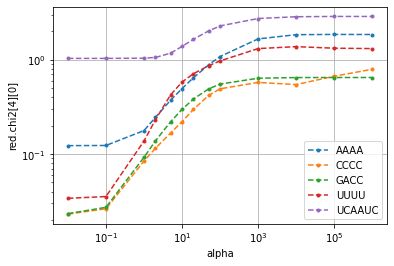

In [ ]:
for i in range(len(Sequences)):
    s='red.chi2[%i][0]' %i
    plt.plot(all_ER['alpha'],all_ER[s],'.--',label=Sequences[i])

plt.xlabel('alpha')
plt.ylabel(s)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.legend()

2. force field fitting

In [ ]:
if_uNOEs=True
userdoc_FFF='Results/ERFFF_alphaonly_skip10/whole_data'
#userdoc_FFF='results2/results2_uNOEs/ERFFF_skip100'

all_FF=pandas.read_csv(os.path.join(userdoc_FFF,"ff_table"),header=0)
all_FF=all_FF.groupby(by='beta').first()
all_FF=all_FF.drop(columns=all_FF.columns[all_FF.columns.str.startswith('Unnamed:')])

all_FF

,lossf,lossf[0],lossf[1],lossf[2],lossf[3],lossf[4],redchi2[0][0],redchi2[0][1],redchi2[1][0],redchi2[1][1],...,kish[0],kish[1],kish[2],kish[3],kish[4],relkish[0],relkish[1],relkish[2],relkish[3],relkish[4]
beta,,,,,,,,,,,,,,,,,,,,,
0.0,4860.281841,1326.245977,72.351957,17.712152,259.528433,3184.443322,3.210655,10.028730,0.865243,0.401813,...,0.000065,0.000061,0.000042,0.000093,0.000278,6.633412,6.189540,4.261725,7.771336,28.179249
100.0,5417.171590,1243.019105,253.103863,77.640279,369.130397,3474.277947,3.051692,8.594168,0.791869,1.079885,...,0.000050,0.000048,0.000032,0.000071,0.000166,5.120011,4.828829,3.272149,5.942538,16.820420


In [ ]:
cols1=all_ER.columns.tolist()
cols1.sort()
print(cols1)

cols2=all_FF.columns.tolist()
cols2.sort()
print(cols2)

['Srel', 'Srel[0]', 'Srel[1]', 'Srel[2]', 'Srel[3]', 'Srel[4]', 'Srel_alpha', 'Srel_alpha[0]', 'Srel_alpha[1]', 'Srel_alpha[2]', 'Srel_alpha[3]', 'Srel_alpha[4]', 'Srel_beta', 'Srel_beta[0]', 'Srel_beta[1]', 'Srel_beta[2]', 'Srel_beta[3]', 'Srel_beta[4]', 'alpha', 'beta', 'lossf', 'lossf[0]', 'lossf[1]', 'lossf[2]', 'lossf[3]', 'lossf[4]', 'red.chi2[0][0]', 'red.chi2[0][1]', 'red.chi2[1][0]', 'red.chi2[1][1]', 'red.chi2[2][0]', 'red.chi2[2][1]', 'red.chi2[3][0]', 'red.chi2[3][1]', 'red.chi2[4][0]', 'red.chi2[4][1]']
['Srel[0]', 'Srel[1]', 'Srel[2]', 'Srel[3]', 'Srel[4]', 'Srel_alpha[0]', 'Srel_alpha[1]', 'Srel_alpha[2]', 'Srel_alpha[3]', 'Srel_alpha[4]', 'Srel_beta[0]', 'Srel_beta[1]', 'Srel_beta[2]', 'Srel_beta[3]', 'Srel_beta[4]', 'kish[0]', 'kish[1]', 'kish[2]', 'kish[3]', 'kish[4]', 'lossf', 'lossf[0]', 'lossf[1]', 'lossf[2]', 'lossf[3]', 'lossf[4]', 'redchi2[0][0]', 'redchi2[0][1]', 'redchi2[1][0]', 'redchi2[1][1]', 'redchi2[2][0]', 'redchi2[2][1]', 'redchi2[3][0]', 'redchi2[3][1]

In [ ]:
all_FF['beta']=all_FF.index
all_FF['alpha']=np.inf

#all_FF.rename(columns={'redchi2[0][0]': 'red.chi2[0]', 'redchi2[1][0]': 'red.chi2[1]', 'redchi2[2][0]': 'red.chi2[2]', 'redchi2[3][0]': 'red.chi2[3]', 'redchi2[4][0]': 'red.chi2[4]'}, inplace=True)
#all_FF.rename(columns={'redchi2[%i][0]' %i: 'redchi2[%i]' %i for i in range(len(Sequences))}, inplace=True)
#all_FF=all_FF.drop(columns=['time','niter'])

filter_col=[col for col in all_FF if col.startswith('kish') or col.startswith('relkish')]
all_FF=all_FF.drop(columns=filter_col)

#for i in range(len(Sequences)):
#    all_FF['red.chi2[%i]' % i]=all_FF['errorf[%s][0]' %i]*2/n_exp[i,0]

#filter_col=[col for col in all_FF if col.startswith('errorf')]
#all_ER=all_ER.drop(columns='n_fails')#filter_col)



In [ ]:
filter_col = [col for col in all_FF if col.startswith('Srel_beta')]
all_FF['Srel_beta']=np.sum(all_FF[filter_col],axis=1)

all_FF['Srel']=all_FF['Srel_beta']
for i in range(len(Sequences)):
    all_FF['Srel[%i]' %i]=all_FF['Srel_beta[%i]' %i]

all_FF['Srel_alpha']=0
#for i in range(len(Sequences)):
#    all_FF['Srel_alpha[%i]' %i]=0


In [ ]:
all_FF=all_FF[sorted(all_FF.columns)]
all_FF.columns

Index(['Srel', 'Srel[0]', 'Srel[1]', 'Srel[2]', 'Srel[3]', 'Srel[4]',
       'Srel_alpha', 'Srel_alpha[0]', 'Srel_alpha[1]', 'Srel_alpha[2]',
       'Srel_alpha[3]', 'Srel_alpha[4]', 'Srel_beta', 'Srel_beta[0]',
       'Srel_beta[1]', 'Srel_beta[2]', 'Srel_beta[3]', 'Srel_beta[4]', 'alpha',
       'beta', 'lossf', 'lossf[0]', 'lossf[1]', 'lossf[2]', 'lossf[3]',
       'lossf[4]', 'redchi2[0][0]', 'redchi2[0][1]', 'redchi2[1][0]',
       'redchi2[1][1]', 'redchi2[2][0]', 'redchi2[2][1]', 'redchi2[3][0]',
       'redchi2[3][1]', 'redchi2[4][0]', 'redchi2[4][1]'],
      dtype='object')

3. force field fitting + ensemble refinement

In [ ]:
userdoc_ERFF=userdoc_FFF

all_ERFF=pandas.read_csv(os.path.join(userdoc_ERFF,"table"),header=0)
s=all_ERFF.columns

In [ ]:
#all_ERFF.rename(columns={'nfail': 'n_fails'},inplace=True)
all_ERFF=all_ERFF.drop(columns=['time','niter','nfail'])

filter_col=[col for col in all_ERFF if col.startswith('kish') or col.startswith('relkish') or col.startswith('Unnamed')]
all_ERFF=all_ERFF.drop(columns=filter_col)

filter_col = [col for col in all_ERFF if col.startswith('Srel[')]
all_ERFF['Srel']=np.sum(all_ERFF[filter_col],axis=1)

filter_col = [col for col in all_ERFF if col.startswith('Srel_alpha[')]
all_ERFF['Srel_alpha']=np.sum(all_ERFF[filter_col],axis=1)

filter_col = [col for col in all_ERFF if col.startswith('Srel_beta[')]
all_ERFF['Srel_beta']=np.sum(all_ERFF[filter_col],axis=1)

#all_ERFF.rename(columns={'redchi2[%i][0]' %i: 'redchi2[%i]' %i for i in range(len(Sequences))}, inplace=True)

all_ERFF=all_ERFF[sorted(all_ERFF.columns)]
all_ERFF.columns

Index(['Srel', 'Srel[0]', 'Srel[1]', 'Srel[2]', 'Srel[3]', 'Srel[4]',
       'Srel_alpha', 'Srel_alpha[0]', 'Srel_alpha[1]', 'Srel_alpha[2]',
       'Srel_alpha[3]', 'Srel_alpha[4]', 'Srel_beta', 'Srel_beta[0]',
       'Srel_beta[1]', 'Srel_beta[2]', 'Srel_beta[3]', 'Srel_beta[4]', 'alpha',
       'beta', 'lossf', 'lossf[0]', 'lossf[1]', 'lossf[2]', 'lossf[3]',
       'lossf[4]', 'redchi2[0][0]', 'redchi2[0][1]', 'redchi2[1][0]',
       'redchi2[1][1]', 'redchi2[2][0]', 'redchi2[2][1]', 'redchi2[3][0]',
       'redchi2[3][1]', 'redchi2[4][0]', 'redchi2[4][1]'],
      dtype='object')